# Bank Marketing

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

## Step #1: Explore and prepare data

In [3]:
df = pd.read_csv("./data/bank-additional-full.csv", delimiter=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Removing unuseful columns and rename the column names for better understanding.

`duration` (numeric) - last contact duration, in seconds.

**Important note:** this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call `y` is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [5]:
cols_to_drop = [
    "duration",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed",
]
df = df.drop(columns=cols_to_drop)

new_column_names = {
    "job": "job_type",
    "default": "default_status",
    "housing": "housing_loan_status",
    "loan": "personal_loan_status",
    "contact": "contact_type",
    "month": "contact_month",
    "day_of_week": "contact_day_of_week",
    "campaign": "num_contacts",
    "pdays": "days_last_contact",
    "previous": "previous_contacts",
    "poutcome": "previous_outcome",
    "y": "result",
}
df = df.rename(columns=new_column_names)

Convert the binary values "yes" and "no" to numeric values 1 and 0

In [6]:
df["result"] = df["result"].replace({"yes": 1, "no": 0})

df.head()

,age,job_type,marital,education,default_status,housing_loan_status,personal_loan_status,contact_type,contact_month,contact_day_of_week,num_contacts,days_last_contact,previous_contacts,previous_outcome,result
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   41188 non-null  int64 
 1   job_type              41188 non-null  object
 2   marital               41188 non-null  object
 3   education             41188 non-null  object
 4   default_status        41188 non-null  object
 5   housing_loan_status   41188 non-null  object
 6   personal_loan_status  41188 non-null  object
 7   contact_type          41188 non-null  object
 8   contact_month         41188 non-null  object
 9   contact_day_of_week   41188 non-null  object
 10  num_contacts          41188 non-null  int64 
 11  days_last_contact     41188 non-null  int64 
 12  previous_contacts     41188 non-null  int64 
 13  previous_outcome      41188 non-null  object
 14  result                41188 non-null  int64 
dtypes: int64(5), object(10)
memory usage

Check the number of unique values in the result column

In [8]:
df["result"].value_counts()

result
0    36548
1     4640
Name: count, dtype: int64

Check the values of nemical columns

In [9]:
df.describe()

,age,num_contacts,days_last_contact,previous_contacts,result
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.112654
std,10.42125,2.770014,186.910907,0.494901,0.316173
min,17.00000,1.000000,0.000000,0.000000,0.000000
25%,32.00000,1.000000,999.000000,0.000000,0.000000
50%,38.00000,2.000000,999.000000,0.000000,0.000000
75%,47.00000,3.000000,999.000000,0.000000,0.000000
max,98.00000,56.000000,999.000000,7.000000,1.000000


In [14]:
df["previous_contacts"].value_counts()

previous_contacts
0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: count, dtype: int64

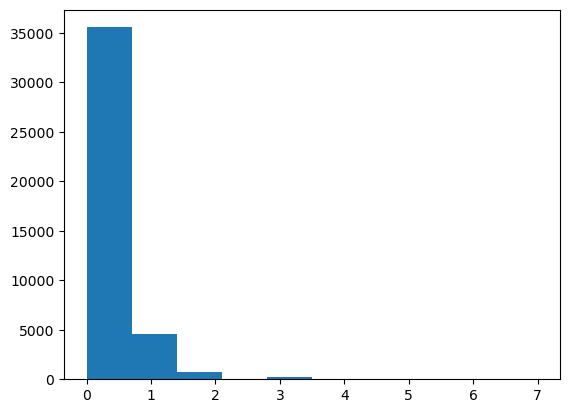

In [17]:
plt.hist(df["previous_contacts"]);

In [18]:
df["days_last_contact"].value_counts()

days_last_contact
999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: count, dtype: int64

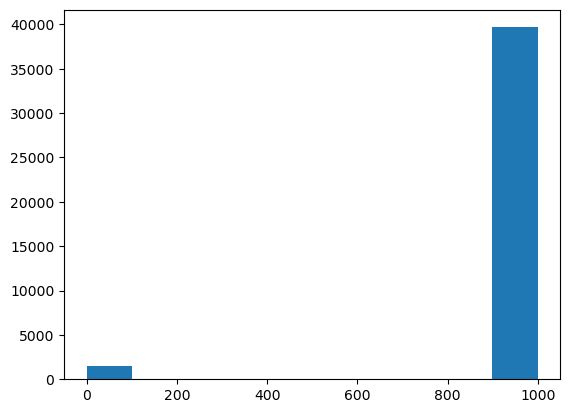

In [19]:
plt.hist(df["days_last_contact"]);

In [12]:
df["previous_contacts"]

0        0
1        0
2        0
3        0
4        0
        ..
41183    0
41184    0
41185    0
41186    0
41187    1
Name: previous_contacts, Length: 41188, dtype: int64

In [20]:
X = df.drop(columns="result")
y = df["result"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=8,
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test  shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test  shape: {y_test.shape}")

X_train shape: (32950, 14)
X_test  shape: (8238, 14)
y_train shape: (32950,)
y_test  shape: (8238,)


## Step #2: Build a pipeline of training

In [21]:
estimators = [
    ("encoder", TargetEncoder()),
    ("clf", XGBClassifier(random_state=8)),
]
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=8, ...))])

## Step #3: Set up hyperparameter tuning

In [23]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
    "clf__max_depth": Integer(2, 5, dtype=int),
    # "clf__learning_rate": Real(0.001, 1.0, prior="log-uniform"),
    # "clf__subsample": Real(0.5, 1.0),
    # "clf__colsample_bytree": Real(0.5, 1.0),
    # "clf__colsample_bylevel": Real(0.5, 1.0),
    # "clf__colsample_bynode": Real(0.5, 1.0),
    # "clf__reg_alpha": Real(0.0, 10.0),
    # "clf__reg_lambda": Real(0.0, 10.0),
    # "clf__gamma": Real(0.0, 10.0),
}

opt = BayesSearchCV(
    pipe, search_space, cv=3, n_iter=10, scoring="roc_auc", random_state=8
)
# in reality, you may consider setting cv and n_iter to higher values

## Step #4: Train the XGBoost model

In [24]:
opt.fit(X_train, y_train)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=N...
                                                       max_cat_to_onehot=None,
                                                       max_delta_step=None,
                                                       max_depth=None,
                                                       max_leaves=None,
                                                       min_child_weight=None,
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       multi_strategy=None,
                                                       n_estimators=None,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       random_state=8, ...))]),
              n_iter=10, random_state=8, scoring='roc_auc',
              search_spaces={'clf__max_depth': Integer(low=2, high=5, prior='uniform', transform='normalize')})

## Step #5: Evaluate the model and make predictions

In [25]:
opt.best_estimator_

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['job_type', 'marital', 'education',
                                     'default_status', 'housing_loan_status',
                                     'personal_loan_status', 'contact_type',
                                     'contact_month', 'contact_day_of_week',
                                     'previous_outcome'])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, d...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=8, ...))])

In [26]:
opt.best_score_

0.7671081269333472

In [27]:
opt.score(X_test, y_test)

0.7814703081513279

In [28]:
opt.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [29]:
opt.predict_proba(X_test)

array([[0.93695545, 0.06304458],
       [0.9617448 , 0.03825519],
       [0.91562843, 0.08437157],
       ...,
       [0.64721906, 0.35278097],
       [0.96222764, 0.03777233],
       [0.83149475, 0.16850525]], dtype=float32)

In [30]:
y_pred = opt.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.99      0.94      7310
           1       0.64      0.21      0.32       928

    accuracy                           0.90      8238
   macro avg       0.77      0.60      0.63      8238
weighted avg       0.88      0.90      0.87      8238



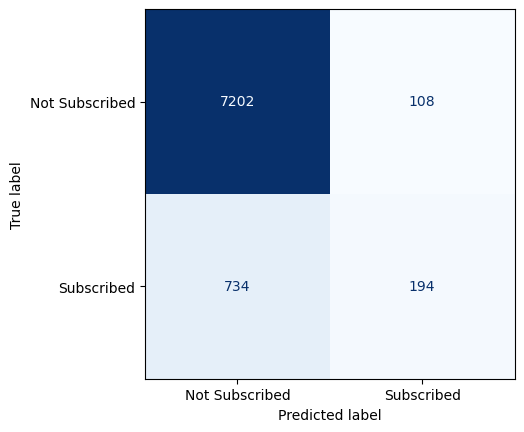

In [31]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    colorbar=False,
    cmap="Blues",
    display_labels=["Not Subscribed", "Subscribed"],
);

**Note**: Because the dataset is very imbalanced, prediction for people who subscribed is not good enough. We need to find some way to figure this out,

## Step #6: Measure feature importance

In [32]:
opt.best_estimator_.steps

[('encoder',
  TargetEncoder(cols=['job_type', 'marital', 'education', 'default_status',
                      'housing_loan_status', 'personal_loan_status',
                      'contact_type', 'contact_month', 'contact_day_of_week',
                      'previous_outcome'])),
 ('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=2, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=Non

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

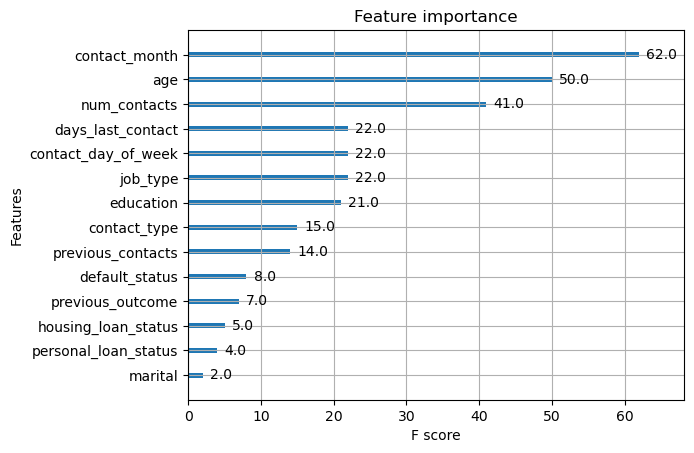

In [33]:
from xgboost import plot_importance

xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)